# Importing Libraries

In [156]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import itertools

# Sklearn
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, cross_val_score,KFold, StratifiedKFold, TimeSeriesSplit
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import SGDRegressor, BayesianRidge
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import make_scorer, confusion_matrix, f1_score
from sklearn.dummy import DummyRegressor, DummyClassifier

# For seasonal decomposition
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

from sklearn.impute import KNNImputer

# Load Dataset

In [157]:
# Dataset folder path
dataset_path = "weatherdata_for_students"

# List all CSV files in the folder
dataset_files = [file for file in os.listdir(dataset_path) if file.endswith('.csv')]

# Initialize an empty list to store DataFrames
colchester_df = []

# Loop over the list of csv files
for file in dataset_files:
    # Construct the full path to the file
    file_path = os.path.join(dataset_path, file)
    header = "infer"
    # Check if the index column exists
    index_column = pd.read_csv(file_path, nrows=1).columns[0] == '0'
    if index_column:
        #Setting header = 1 so that we dont consider index column
        header = 1
        
    # Read the csv file into a pandas DataFrame and append to the list
    df = pd.read_csv(file_path, header = header)
    
    if "colchester" in file_path:   
        colchester_df.append(df)
        
    
# Concatenate all the DataFrames in the list into one
combined_colchester_df = pd.concat(colchester_df, ignore_index=True)

### - Colchester Dataset
Records = 188024 from 196 files

In [158]:
df = combined_colchester_df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188024 entries, 0 to 188023
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   datetime          188024 non-null  object 
 1   temp              187606 non-null  float64
 2   dew               187600 non-null  float64
 3   humidity          187602 non-null  float64
 4   precip            187437 non-null  float64
 5   precipprob        187590 non-null  float64
 6   preciptype        19448 non-null   object 
 7   snow              186478 non-null  float64
 8   snowdepth         186429 non-null  float64
 9   windspeed         187627 non-null  float64
 10  winddir           187595 non-null  float64
 11  sealevelpressure  180462 non-null  float64
 12  cloudcover        184405 non-null  float64
 13  solarradiation    94894 non-null   float64
 14  uvindex           94897 non-null   float64
 15  solarenergy       94908 non-null   float64
dtypes: float64(14), obje

In [159]:
# Converting date to datetime
df['datetime'] = pd.to_datetime(df['datetime'], dayfirst=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188024 entries, 0 to 188023
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   datetime          188024 non-null  datetime64[ns]
 1   temp              187606 non-null  float64       
 2   dew               187600 non-null  float64       
 3   humidity          187602 non-null  float64       
 4   precip            187437 non-null  float64       
 5   precipprob        187590 non-null  float64       
 6   preciptype        19448 non-null   object        
 7   snow              186478 non-null  float64       
 8   snowdepth         186429 non-null  float64       
 9   windspeed         187627 non-null  float64       
 10  winddir           187595 non-null  float64       
 11  sealevelpressure  180462 non-null  float64       
 12  cloudcover        184405 non-null  float64       
 13  solarradiation    94894 non-null   float64       
 14  uvin

# Data Exploration

First we will calculate energy generated by solar and wind so that we can find surplus.

### Energy Generation formulas

We will be considering only wind power as UK is known for the one of the best location for wind power in the world.

Ref:https://en.wikipedia.org/wiki/Wind_power_in_the_United_Kingdom


#### Wind Energy

We are assuming we have 1500 household that can take advantage of surplus energy.

Considering 
- 500 household of flat or 1 bedroom = 1800 kWH per year
- 500 household of 2-3 bedrooms = 2700 kWH per year
- 500 household of 4-5 bedrooms = 4100 kWH per year

Average electricity consumption of household 

- Average KW consumed per hour = ((500 * 1800) + (500 * 2700) + (500 * 4100))/8760 = 490 KW (Total consumption)

Ref: https://www.geeksforgeeks.org/wind-energy-formula/

Ref: https://www.ofgem.gov.uk/information-consumers/energy-advice-households/average-gas-and-electricity-use-explained



In [160]:
#Constants based on assumptions
total_consumption_per_hour = 490 # KW
blade_length = 57.5 # m
wind_energy_threshold = total_consumption_per_hour * 3  # KW
density = 1.23 #kg/m
no_of_turbines = 50
def calculate_wind_electricity(row):
    wind_speed = row['windspeed']
    swept_area = blade_length * 3.14
    # Converting speed into m/s
    wind_speed = wind_speed / 3.6 
    # Calculating wind energy
    power = 0.5 * density * swept_area * (wind_speed)**3 
    power = no_of_turbines * power
    return round(power / 1000, 2) # KW

## Data Description

In [161]:
df.describe()

,datetime,temp,dew,humidity,precip,precipprob,snow,snowdepth,windspeed,winddir,sealevelpressure,cloudcover,solarradiation,uvindex,solarenergy
count,188024,187606.000000,187600.000000,187602.000000,187437.000000,187590.000000,186478.000000,186429.000000,187627.000000,187595.000000,180462.000000,184405.000000,94894.000000,94897.000000,94908.000000
mean,2011-08-24 00:38:52.406501376,10.503048,7.190720,81.596979,0.067773,10.276578,0.001008,0.062193,15.998126,198.262143,1013.922618,59.510905,122.256657,1.203104,0.439357
min,2000-01-01 00:00:00,-9.600000,-10.800000,22.430000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2005-06-20 14:45:00,6.100000,3.600000,73.490000,0.000000,0.000000,0.000000,0.000000,10.100000,126.000000,1008.300000,34.000000,0.000000,0.000000,0.000000
50%,2011-06-28 05:30:00,10.300000,7.400000,85.480000,0.000000,0.000000,0.000000,0.000000,14.600000,218.000000,1015.500000,66.600000,9.000000,0.000000,0.000000
75%,2017-09-22 19:15:00,14.700000,10.900000,92.680000,0.000000,0.000000,0.000000,0.000000,20.700000,267.000000,1022.000000,88.900000,169.500000,2.000000,0.600000
max,2024-01-05 09:00:00,35.000000,21.500000,100.000000,84.324000,100.000000,9.100000,15.230000,74.700000,360.000000,1048.900000,100.000000,1054.000000,10.000000,3.800000
std,NaN,6.004301,4.956358,14.085087,0.623144,30.357300,0.043173,0.602604,7.916611,95.653613,29.713385,31.985577,198.631750,2.006343,0.715817


## Handling Date

In [162]:
# Checking the range of dates in our data
print(df['datetime'].min(), df['datetime'].max())

2000-01-01 00:00:00 2024-01-05 09:00:00


In [163]:
# Let's say we want to create extra columns: month, year, and week of the year
df['hour'] = df['datetime'].dt.hour
df['day'] = df['datetime'].dt.day
df['month'] = df['datetime'].dt.month
df['year'] = df['datetime'].dt.year
df['week_of_year'] = df['datetime'].dt.isocalendar().week
# Let's make the date column the index of the dataframe for easier slicing
df.set_index('datetime', inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 188024 entries, 2000-01-01 00:00:00 to 2024-01-05 09:00:00
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   temp              187606 non-null  float64
 1   dew               187600 non-null  float64
 2   humidity          187602 non-null  float64
 3   precip            187437 non-null  float64
 4   precipprob        187590 non-null  float64
 5   preciptype        19448 non-null   object 
 6   snow              186478 non-null  float64
 7   snowdepth         186429 non-null  float64
 8   windspeed         187627 non-null  float64
 9   winddir           187595 non-null  float64
 10  sealevelpressure  180462 non-null  float64
 11  cloudcover        184405 non-null  float64
 12  solarradiation    94894 non-null   float64
 13  uvindex           94897 non-null   float64
 14  solarenergy       94908 non-null   float64
 15  hour              188024 non-null 

- This dataset has records for 24 years.

In [164]:
# For now we will consider only the 10 years of data i.e 2014 - 2024
df = df.loc['2014-01':'2024-12'] 

## Splitting Data into Train and Test 
- We have 10 years of data.
- We will consider the first 8 years for training and the rest for testing

In [165]:
train_set = df.loc['2014-01':'2021-12']
validation_set = df.loc['2022-01':'2022-12']
test_set = df.loc['2023-01':]

## Handling Missing Values

In [166]:
# Checking missing values
print(df.isna().any())

temp                 True
dew                  True
humidity             True
precip               True
precipprob           True
preciptype           True
snow                 True
snowdepth            True
windspeed            True
winddir              True
sealevelpressure     True
cloudcover           True
solarradiation       True
uvindex              True
solarenergy          True
hour                False
day                 False
month               False
year                False
week_of_year        False
dtype: bool


In [167]:
# Features having missing values
features = ["temp","dew", "humidity", "windspeed","precip","precipprob","snow","snowdepth",
            "winddir","sealevelpressure","cloudcover","solarradiation","uvindex","solarenergy"]
df[features].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 74865 entries, 2014-01-01 00:00:00 to 2024-01-05 09:00:00
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   temp              74701 non-null  float64
 1   dew               74699 non-null  float64
 2   humidity          74697 non-null  float64
 3   windspeed         74700 non-null  float64
 4   precip            74710 non-null  float64
 5   precipprob        74691 non-null  float64
 6   snow              74520 non-null  float64
 7   snowdepth         74515 non-null  float64
 8   winddir           74693 non-null  float64
 9   sealevelpressure  74644 non-null  float64
 10  cloudcover        74701 non-null  float64
 11  solarradiation    73687 non-null  float64
 12  uvindex           73671 non-null  float64
 13  solarenergy       73692 non-null  float64
dtypes: float64(14)
memory usage: 10.6 MB


In [168]:
# We cannot drop missing value rows because we might lose some useful information.
df[features] = df[features].ffill()
df[features] = df[features].bfill()

In [169]:
# Checking missing values
print(df.isna().any())

temp                False
dew                 False
humidity            False
precip              False
precipprob          False
preciptype           True
snow                False
snowdepth           False
windspeed           False
winddir             False
sealevelpressure    False
cloudcover          False
solarradiation      False
uvindex             False
solarenergy         False
hour                False
day                 False
month               False
year                False
week_of_year        False
dtype: bool


## Handling Duplicates

In [170]:
# Checking duplicates in the whole dataframe
duplicates = df[df.index.duplicated(keep=False)]
len(duplicates) # Total 18 duplicates
duplicates.head(20)

,temp,dew,humidity,precip,precipprob,preciptype,snow,snowdepth,windspeed,winddir,sealevelpressure,cloudcover,solarradiation,uvindex,solarenergy,hour,day,month,year,week_of_year
datetime,,,,,,,,,,,,,,,,,,,,
2014-10-26 01:00:00,11.4,8.5,82.46,0.000,0.0,NaN,0.0,0.0,15.2,203.0,1020.5,85.3,0.0,0.0,0.0,1,26,10,2014,43
2014-10-26 01:00:00,11.5,8.6,82.66,0.000,0.0,NaN,0.0,0.0,16.4,202.0,1020.6,95.6,0.0,0.0,0.0,1,26,10,2014,43
2015-10-25 01:00:00,6.8,5.4,90.85,0.728,100.0,rain,0.0,0.0,13.8,291.0,1020.7,0.0,0.0,0.0,0.0,1,25,10,2015,43
2015-10-25 01:00:00,6.1,5.0,92.44,0.000,0.0,NaN,0.0,0.0,11.5,287.0,1021.6,3.5,0.0,0.0,0.0,1,25,10,2015,43
2016-10-30 01:00:00,8.9,8.7,98.87,0.000,0.0,NaN,0.0,0.0,3.5,283.0,1032.6,32.9,0.0,0.0,0.0,1,30,10,2016,43
2016-10-30 01:00:00,8.6,8.4,98.79,0.000,0.0,NaN,0.0,0.0,3.1,281.0,1032.3,7.2,0.0,0.0,0.0,1,30,10,2016,43
2018-10-28 01:00:00,4.3,3.5,94.19,0.413,100.0,rain,0.0,0.0,16.0,356.0,1015.9,61.3,0.0,0.0,0.0,1,28,10,2018,43
2018-10-28 01:00:00,3.7,3.1,96.05,0.000,0.0,NaN,0.0,0.0,12.9,355.0,1016.2,32.7,0.0,0.0,0.0,1,28,10,2018,43
2019-10-27 01:00:00,6.1,4.7,91.13,0.201,100.0,rain,0.0,0.0,14.1,285.0,1016.5,62.0,0.0,0.0,0.0,1,27,10,2019,43


In [171]:
# Let's keep the first one
df = df[~df.index.duplicated(keep='first')]
len(df)

74856

## TimeSeries Plots

Wind energy generation calculation depends on wind speed thats why we will be analyzing windspeed.

In [172]:
def generate_time_series_plot(start_date,end_date,feature,title):
    df_new = df[start_date:end_date]
    plt.figure(figsize=(16,8))
    plt.plot(df_new.index, df_new[feature])
    plt.xlabel('Year')
    plt.ylabel(title)
    return df_new

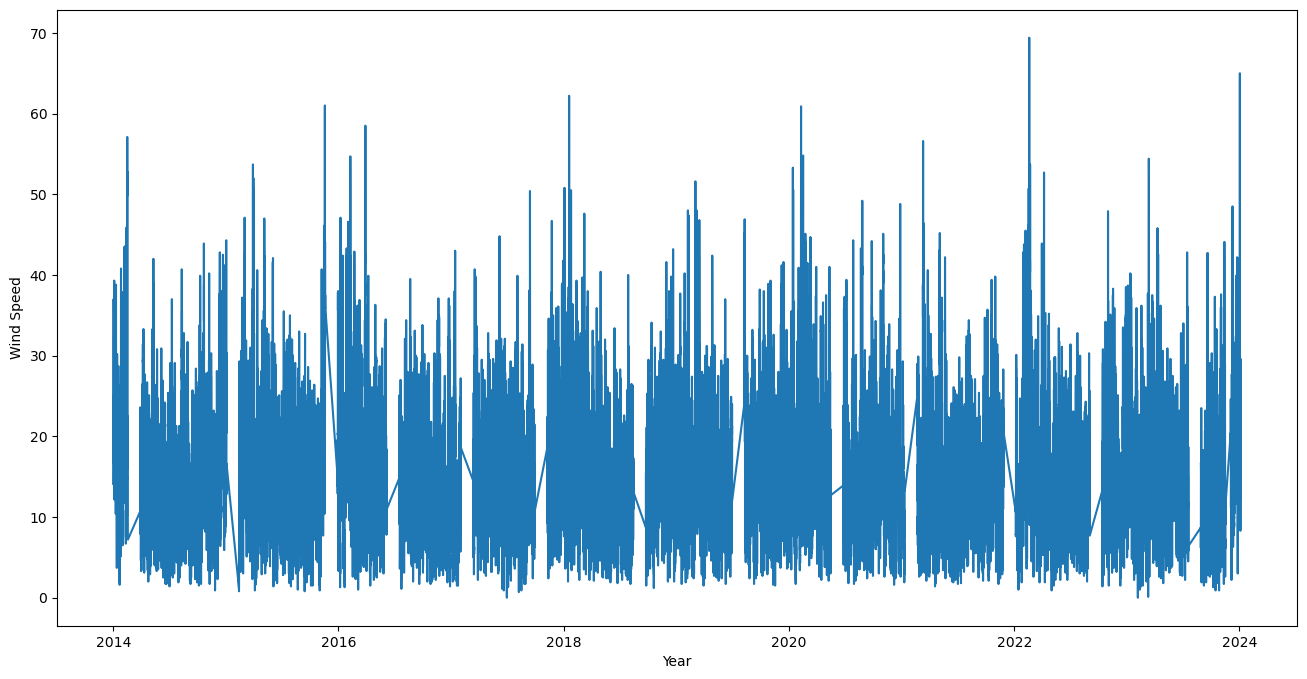

In [173]:
#Generating time series plot
start_date = "2014-01-01 00:00:00"
end_date = "2024-07-30 00:00:00"
df_new = generate_time_series_plot(start_date,end_date,'windspeed','Wind Speed')

#### Insights
- In this plot we have around 10 cycles that corresponds to the 10 years of data. (2014 - 2024)
- We can see that there are many drops through out these years.
- For better clarity, lets look at one of them.

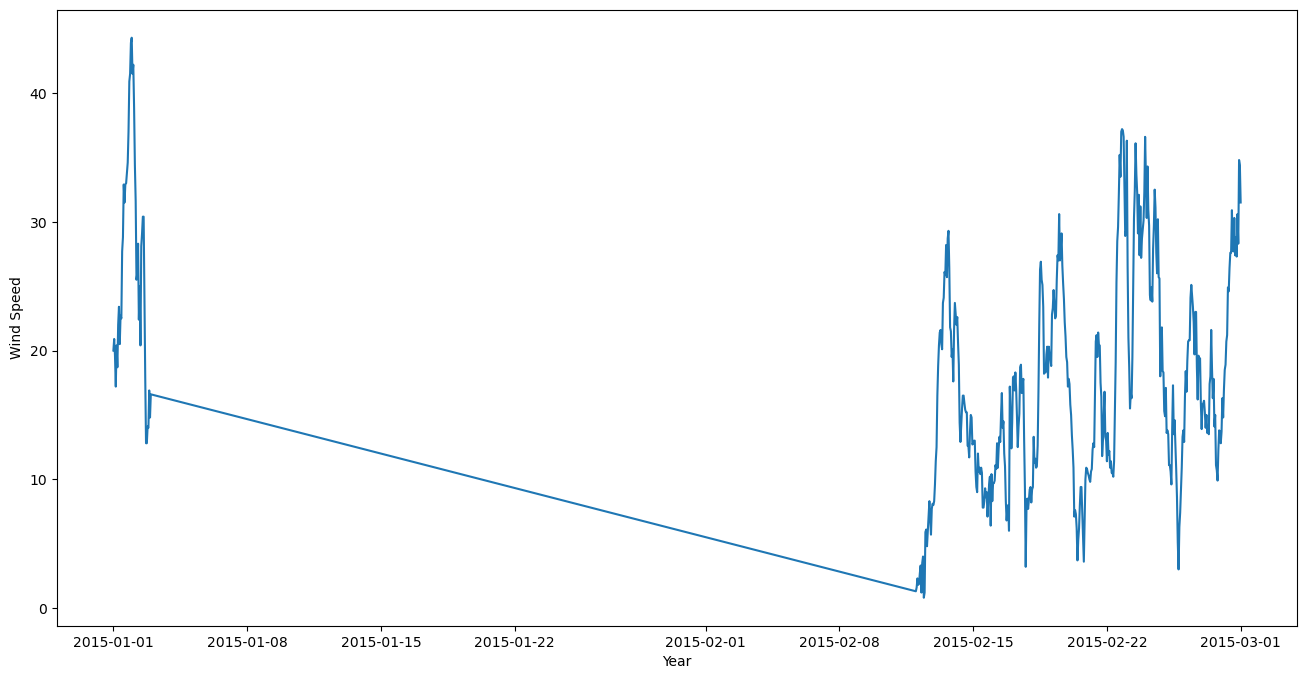

In [174]:
#Generating time series plot
chunk_start_date = "2015-01-01 00:00:00"
chunk_end_date = "2015-03-01 00:00:00"
df_new = generate_time_series_plot(chunk_start_date,chunk_end_date,'windspeed','Wind Speed')

- This looks like that we have some missing dates here.

## Handling Missing Dates

In [175]:
len(df_new)

457

In [176]:
# Check for missing days
print("Missing Days: ",df_new.reindex(pd.date_range('2015-01', '2015-03' )).isnull().all(1).sum()) # 40 days missing
df_new.reindex(pd.date_range('2015-01', '2015-03')).isnull().all(1)

Missing Days:  40


2015-01-01    False
2015-01-02    False
2015-01-03     True
2015-01-04     True
2015-01-05     True
2015-01-06     True
2015-01-07     True
2015-01-08     True
2015-01-09     True
2015-01-10     True
2015-01-11     True
2015-01-12     True
2015-01-13     True
2015-01-14     True
2015-01-15     True
2015-01-16     True
2015-01-17     True
2015-01-18     True
2015-01-19     True
2015-01-20     True
2015-01-21     True
2015-01-22     True
2015-01-23     True
2015-01-24     True
2015-01-25     True
2015-01-26     True
2015-01-27     True
2015-01-28     True
2015-01-29     True
2015-01-30     True
2015-01-31     True
2015-02-01     True
2015-02-02     True
2015-02-03     True
2015-02-04     True
2015-02-05     True
2015-02-06     True
2015-02-07     True
2015-02-08     True
2015-02-09     True
2015-02-10     True
2015-02-11     True
2015-02-12    False
2015-02-13    False
2015-02-14    False
2015-02-15    False
2015-02-16    False
2015-02-17    False
2015-02-18    False
2015-02-19    False


#### Insights
- We now have clarity that the drop means that we have missing dates.
- Now we will handle missing dates for this chunk

In [177]:
# Adding missing dates
df = df.reindex(pd.date_range(start=df.index[0], end=df.index[-1], freq='H'))
print("Data chunk size: ",len(df_new))

# Now we should have missing values
print(df.isna().sum())

Data chunk size:  457
temp                12898
dew                 12898
humidity            12898
precip              12898
precipprob          12898
preciptype          78195
snow                12898
snowdepth           12898
windspeed           12898
winddir             12898
sealevelpressure    12898
cloudcover          12898
solarradiation      12898
uvindex             12898
solarenergy         12898
hour                12898
day                 12898
month               12898
year                12898
week_of_year        12898
dtype: int64


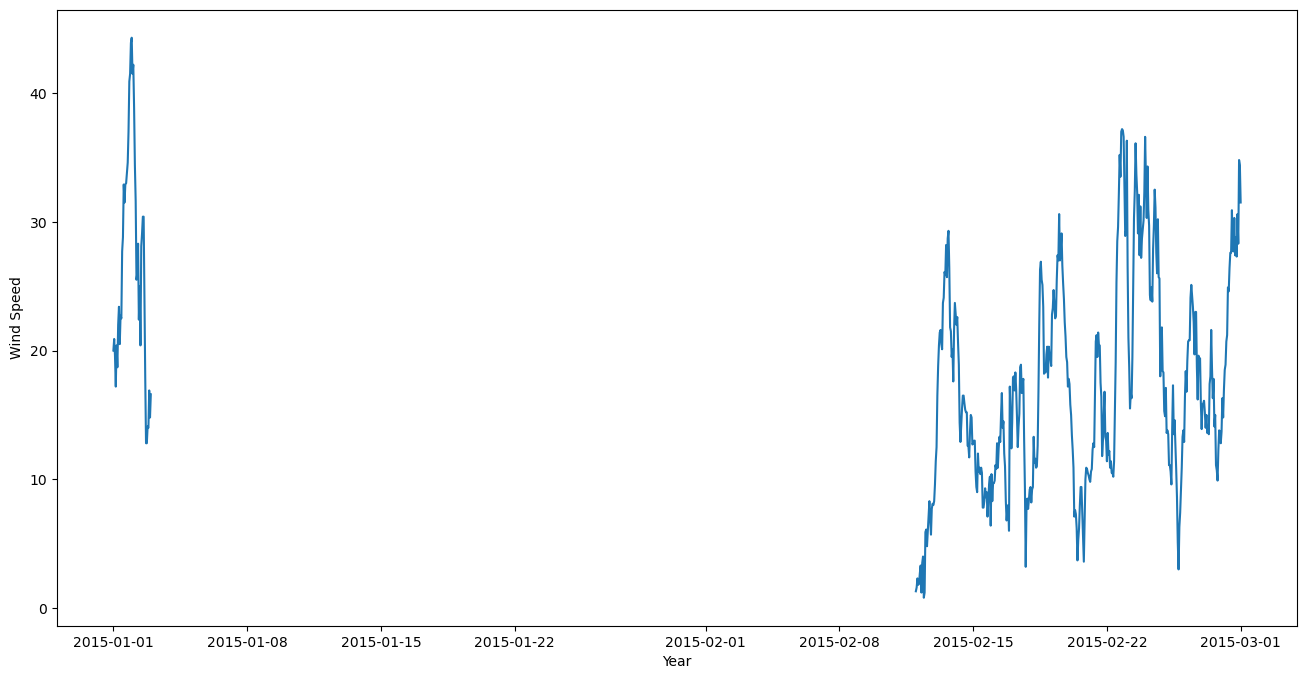

In [178]:
# Generating time series plot 
df_new = generate_time_series_plot(chunk_start_date,chunk_end_date,'windspeed','Wind Speed')

- We can clearly see the missing dates now

In [179]:
# Considering windspeed feature
df_chunk = df_new.copy()
df_chunk = df_chunk.loc[:, 'windspeed'].to_frame()
df_chunk

,windspeed
2015-01-01 00:00:00,20.0
2015-01-01 01:00:00,20.9
2015-01-01 02:00:00,19.6
2015-01-01 03:00:00,17.2
2015-01-01 04:00:00,20.4
...,...
2015-02-28 20:00:00,30.6
2015-02-28 21:00:00,28.3
2015-02-28 22:00:00,34.8
2015-02-28 23:00:00,34.4


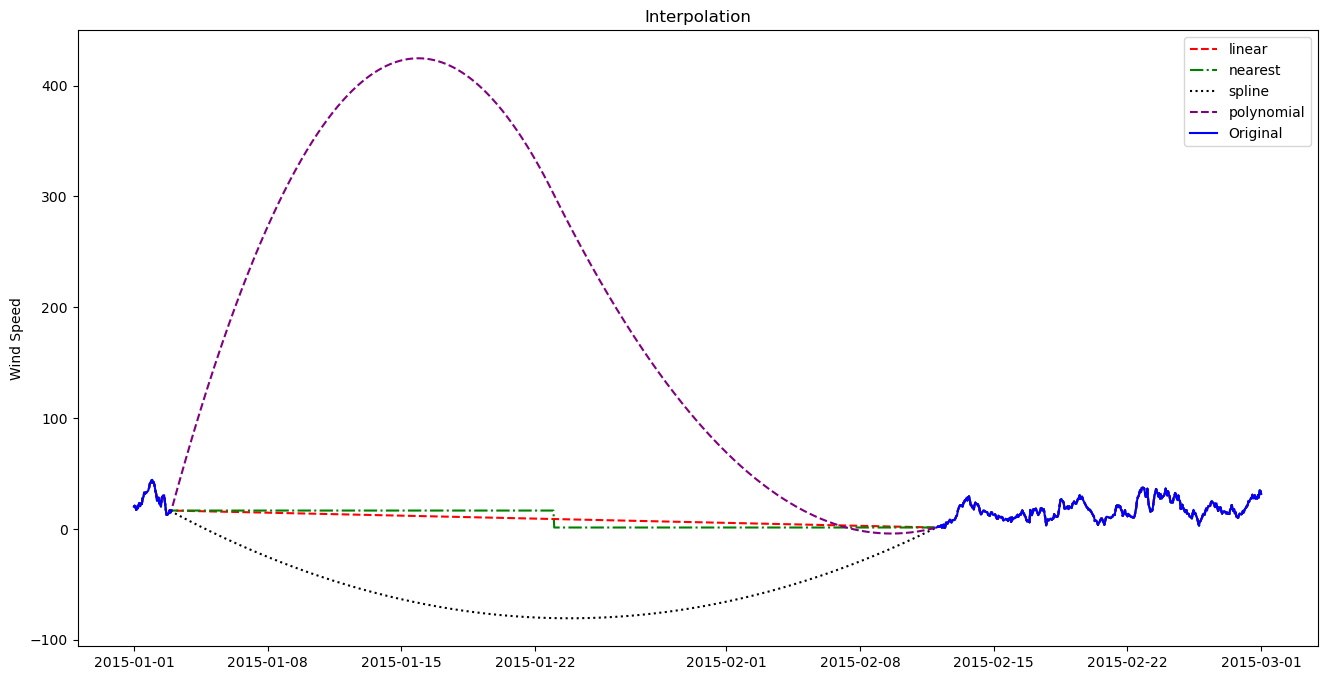

In [180]:
# Trying different interpolation methods.

df_chunk['linear_interp'] = df_chunk['windspeed'].interpolate(method='linear')
df_chunk['nearest_interp'] = df_chunk['windspeed'].interpolate(method='nearest')
df_chunk['spline_interp'] = df_chunk['windspeed'].interpolate(method='spline', order=2)
df_chunk['polynomial_interp'] = df_chunk['windspeed'].interpolate(method="polynomial", order=2)

# Plot
fig, ax = plt.subplots(figsize=(16,8))

plt.plot(df_chunk.index, df_chunk['linear_interp'], linestyle='--', color='red', label='linear')
plt.plot(df_chunk.index, df_chunk['nearest_interp'], linestyle='-.', color='green', label='nearest')
plt.plot(df_chunk.index, df_chunk['spline_interp'], linestyle=':', color='black', label='spline')
plt.plot(df_chunk.index, df_chunk['polynomial_interp'], linestyle='--', color='purple', label='polynomial')
plt.plot(df_chunk.index, df_chunk['windspeed'], label='Original', color='blue')

plt.legend()
plt.ylabel('Wind Speed')
_=plt.title('Interpolation')

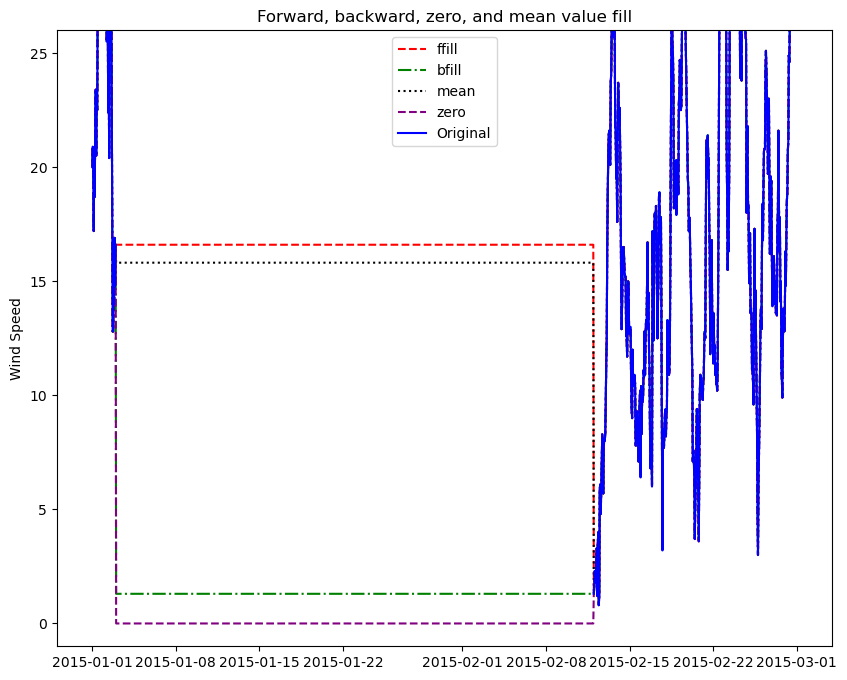

In [181]:
#Forward Fill
df_chunk['ffill'] = df_chunk['windspeed'].ffill()
# Backward Fill
df_chunk['bfill'] = df_chunk['windspeed'].bfill()
# Mean Value Fill
df_chunk['meanfill'] = df_chunk['windspeed'].fillna(df['windspeed'].mean())  # Note that we're using the mean of df, not of df2
# Fill with 0s
df_chunk['zerofill'] = df_chunk['windspeed'].fillna(0)

# Plot
fig, ax = plt.subplots(figsize=(10,8))

plt.plot(df_chunk.index, df_chunk['ffill'], label='ffill', linestyle='--', color='red')
plt.plot(df_chunk.index, df_chunk['bfill'], label='bfill', linestyle='-.', color='green')
plt.plot(df_chunk.index, df_chunk['meanfill'], label='mean', linestyle=':', color='black')
plt.plot(df_chunk.index, df_chunk['zerofill'], linestyle='--', color='purple', label='zero')
plt.plot(df_chunk.index, df_chunk['windspeed'], color='blue', label='Original')
plt.legend()
plt.ylabel('Wind Speed')
plt.ylim(-1, 26)
_=plt.title('Forward, backward, zero, and mean value fill')

In [182]:
# Taking linear interpolation
df.loc[chunk_start_date:chunk_end_date, 'windspeed'] = df_chunk['linear_interp']

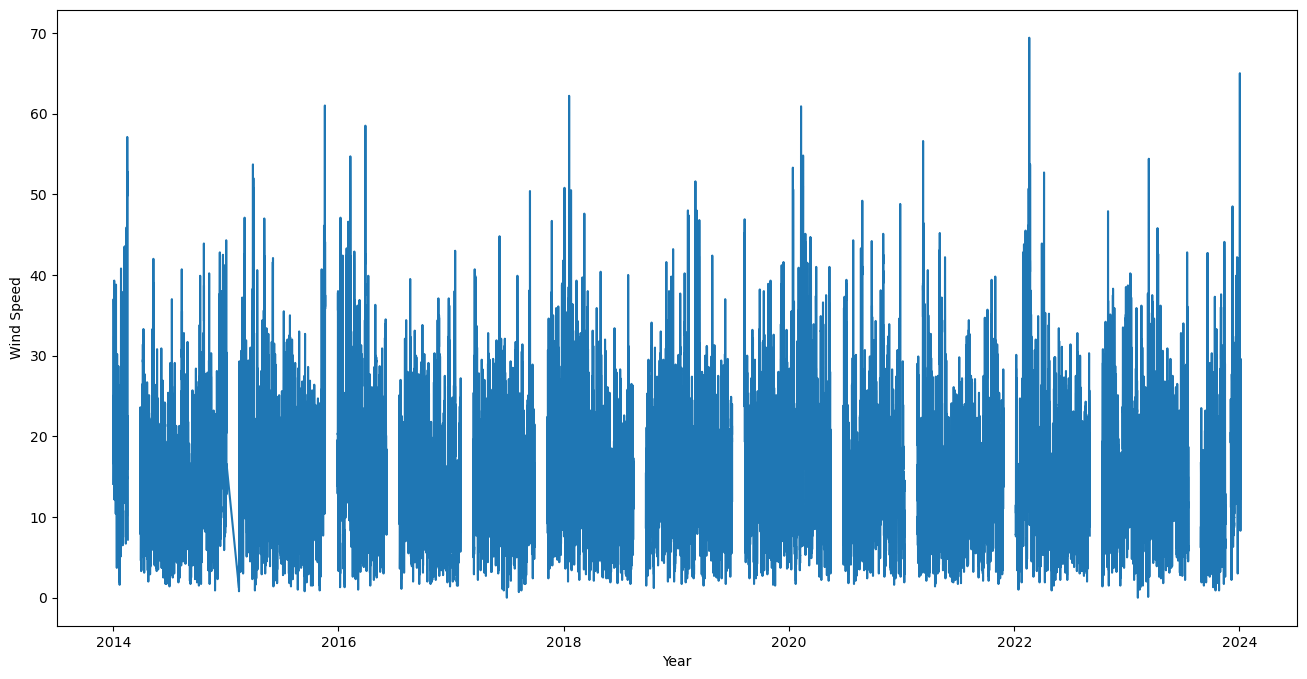

In [183]:
# Now considering the whole dataset plot
start_date = "2014-01-01 00:00:00"
end_date = "2024-05-01 00:00:00"
df_new = generate_time_series_plot(start_date,end_date,'windspeed','Wind Speed')

In [184]:
# We should have missing values
print("Missing values:")
print(df.isna().sum())

# Filling missing values using linear interpolation
df[features] = df[features].interpolate(method='linear')

# Re-compute the columns we originally created
df['month'] = df.index.month
df['year'] = df.index.year
df['week_of_year'] = df.index.isocalendar().week

print("Dataset Info:")
# Now we should NOT have missing values
print(df.isna().sum()) 

Missing values:
temp                12898
dew                 12898
humidity            12898
precip              12898
precipprob          12898
preciptype          78195
snow                12898
snowdepth           12898
windspeed           11938
winddir             12898
sealevelpressure    12898
cloudcover          12898
solarradiation      12898
uvindex             12898
solarenergy         12898
hour                12898
day                 12898
month               12898
year                12898
week_of_year        12898
dtype: int64
Dataset Info:
temp                    0
dew                     0
humidity                0
precip                  0
precipprob              0
preciptype          78195
snow                    0
snowdepth               0
windspeed               0
winddir                 0
sealevelpressure        0
cloudcover              0
solarradiation          0
uvindex                 0
solarenergy             0
hour                12898
day                 1

## Handling Categorical values

In [185]:
# preciptype is a categorical value 
df = pd.get_dummies(df)
df.info()
# Now we should NOT have missing values
print(df.isna().sum()) 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 87754 entries, 2014-01-01 00:00:00 to 2024-01-05 09:00:00
Freq: H
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   temp                  87754 non-null  float64
 1   dew                   87754 non-null  float64
 2   humidity              87754 non-null  float64
 3   precip                87754 non-null  float64
 4   precipprob            87754 non-null  float64
 5   snow                  87754 non-null  float64
 6   snowdepth             87754 non-null  float64
 7   windspeed             87754 non-null  float64
 8   winddir               87754 non-null  float64
 9   sealevelpressure      87754 non-null  float64
 10  cloudcover            87754 non-null  float64
 11  solarradiation        87754 non-null  float64
 12  uvindex               87754 non-null  float64
 13  solarenergy           87754 non-null  float64
 14  hour                  74856

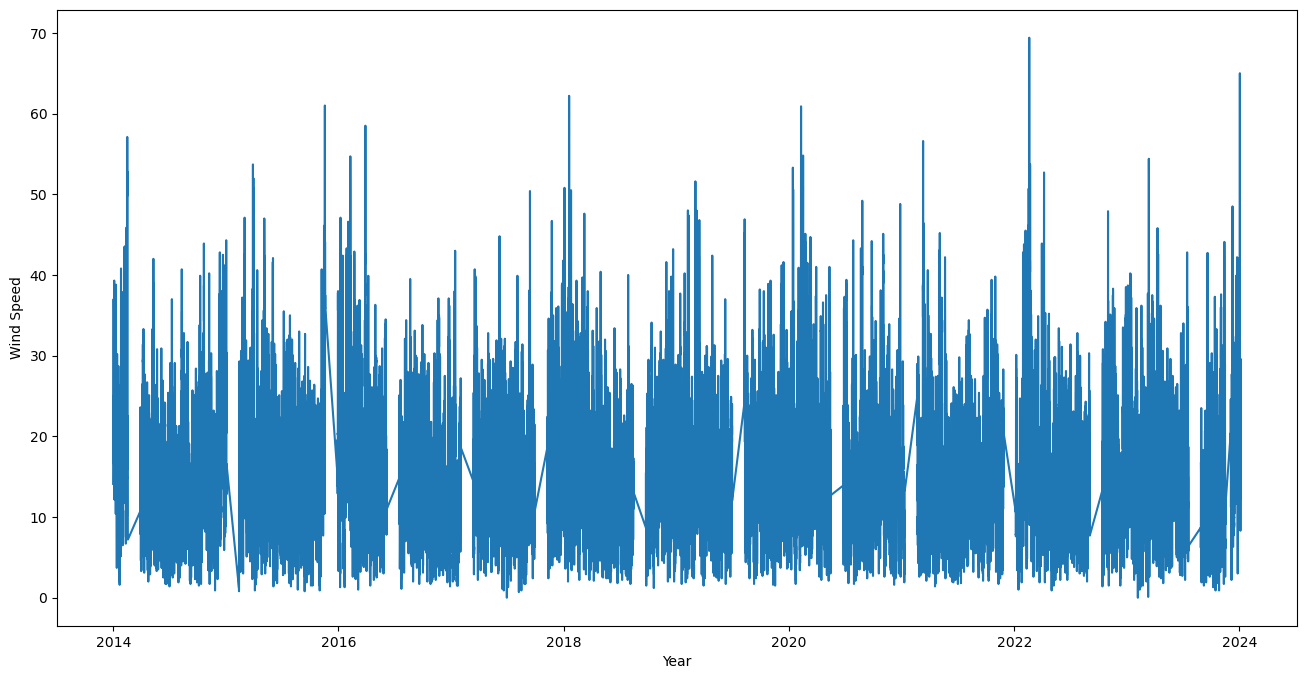

In [186]:
df_new = generate_time_series_plot(start_date,end_date,'windspeed','Wind Speed')

## Handling Outliers

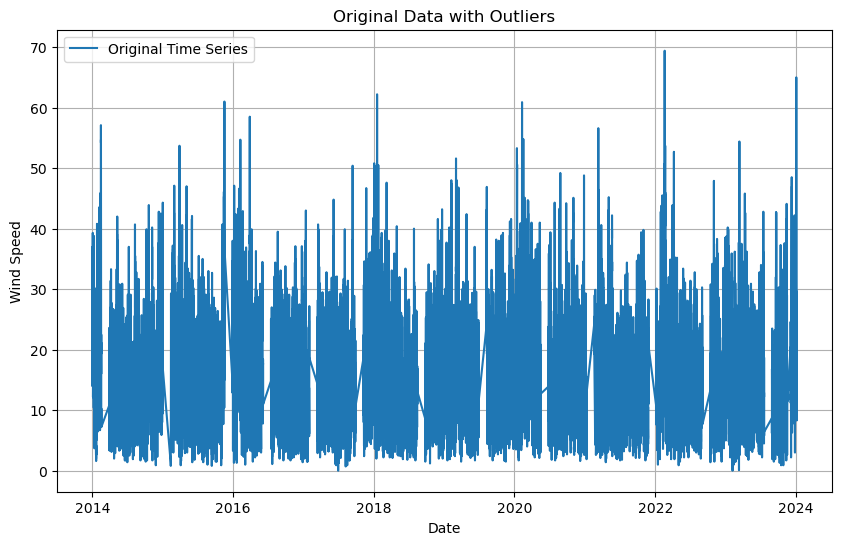

In [187]:
features = ["dew", "humidity", "windspeed","winddir",
            "sealevelpressure","cloudcover","solarradiation","uvindex",
            "solarenergy"]
# Plot the original time series
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['windspeed'], label='Original Time Series')
plt.title('Original Data with Outliers')
plt.xlabel('Date')
plt.ylabel('Wind Speed')
plt.legend()
plt.grid(True)
plt.show()

We will be using moving average for smoothing the time series.

Moving Average: 
- Smooth the time series by replacing each data point with the average of neighboring points within a specified window size.

In [188]:
# Window size for moving average smoothing
window_size = 7

# Smooth the time series using moving average
smoothed_values = df['windspeed'].rolling(window=window_size, min_periods=1).mean()

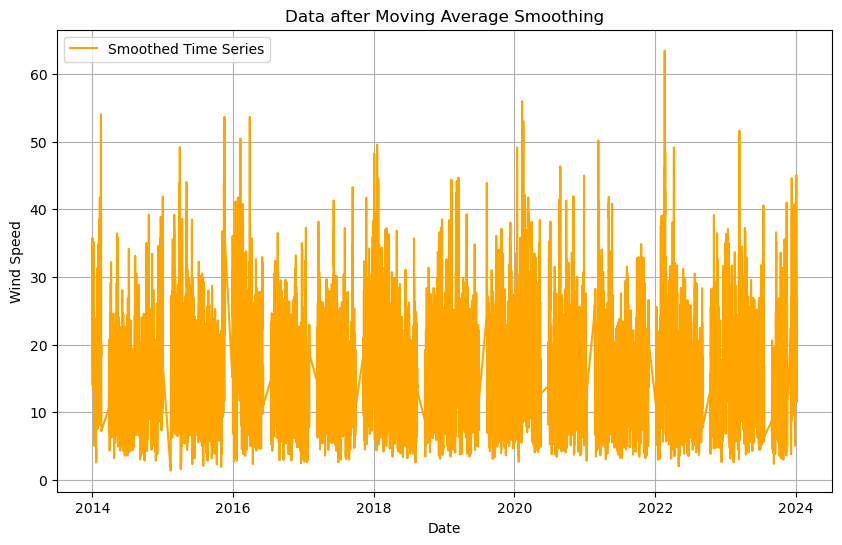

In [189]:
# Plot the smoothed time series
plt.figure(figsize=(10, 6))
plt.plot(df.index, smoothed_values, label='Smoothed Time Series', color='orange')
plt.title('Data after Moving Average Smoothing')
plt.xlabel('Date')
plt.ylabel('Wind Speed')
plt.legend()
plt.grid(True)
plt.show()

In [190]:
df[features] = df[features].rolling(window=window_size, min_periods=1).mean()

In [191]:
# Re-compute the columns we originally created
df['day'] = df.index.day
df['hour'] = df.index.hour
df['month'] = df.index.month
df['year'] = df.index.year
df['week_of_year'] = df.index.isocalendar().week

## Trend plot

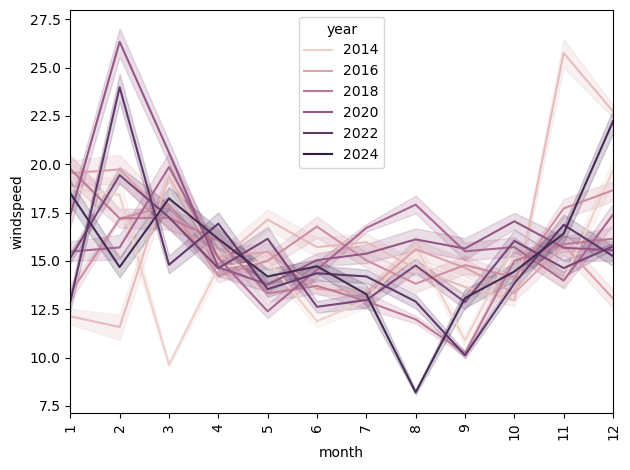

In [192]:
# Visualise trends across years
sns.lineplot(x='month', y='windspeed', data=df, hue='year')
_=plt.xticks(np.arange(1, 13), rotation=90)
_=plt.xlim(1, 12)  # limit x-axis
_=plt.tight_layout()

#### Insights

- We see seasonal patterns in the wind speed throughout the year.
- Lower wind speeds around the middle of the year and higher speed towards the beginning and end.
- This could indicate stronger winds in winter and milder winds in summer.

This information can help us in taking decisions in Assignment 2.

## Decomposition

In [193]:
# Time series decomposition
# Let's downsample our timeseries first: average windspeed per month
data_ds = df.loc['2014-01':'2021-01','windspeed'].resample('M').mean().ffill().to_frame()  # one value per month
data_ds

,windspeed
2014-01-31,18.764240
2014-02-28,18.412706
2014-03-31,9.626235
2014-04-30,14.647798
2014-05-31,15.001133
...,...
2020-09-30,15.637123
2020-10-31,17.047081
2020-11-30,15.677421
2020-12-31,15.548502


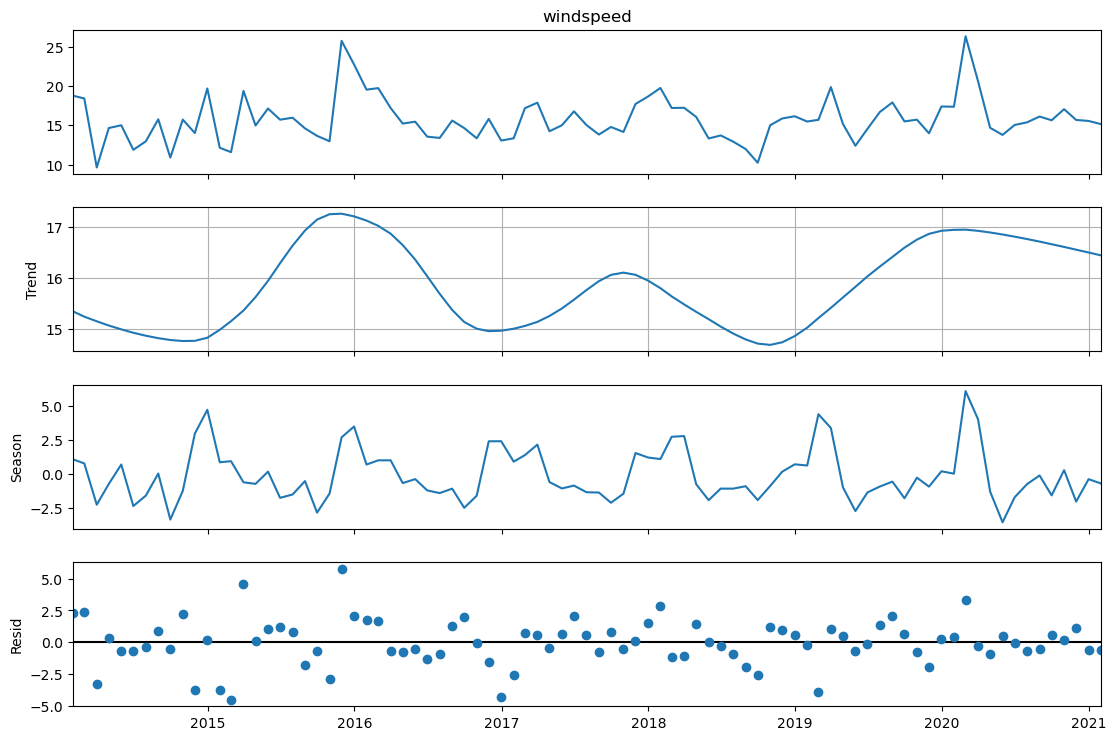

In [194]:
# Decomposition on the resampled dataset
decomposition = STL(data_ds['windspeed']).fit()
fig = decomposition.plot()
fig.set_size_inches(12,8)
fig.axes[1].grid() # so we can check a bit better if there's a trend or not

### Insights
- There's no clear pattern showing that wind speeds are consistently getting faster or slower over the years.
- Every year, wind speeds go up and down in a regular pattern, likely depending on the changing seasons.
- The residuals are within 5 m/s and symmetrically distributed around 0 - that's the noise we won't be able to predict.

## Stationarity Test

In [195]:
# As our target variable will mostly be dependant on windspeed feature
# Checking whether the windspeed is stationary or not

result = adfuller(df['windspeed'])

print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))


ADF Statistic: -22.069052442622326
p-value: 0.0
Critical Values:
	1%: -3.430424577661925
	5%: -2.861572962107161
	10%: -2.5667875445851083


#### Insights
- As p-value is 0 < 0.05, that means time series does not have a unit root.
- The value of ADF statistic is more negative than the critical values at all significance levels, it further supports the rejection of the null hypothesis.
- Based on these results, we can conclude that the time series maybe stationary.
- Despite the ADF test indicating stationarity, the presence of periodic patterns in the plots suggests otherwise. Therefore, in this scenario, the time series cannot be considered stationary.

## Auto Correlation

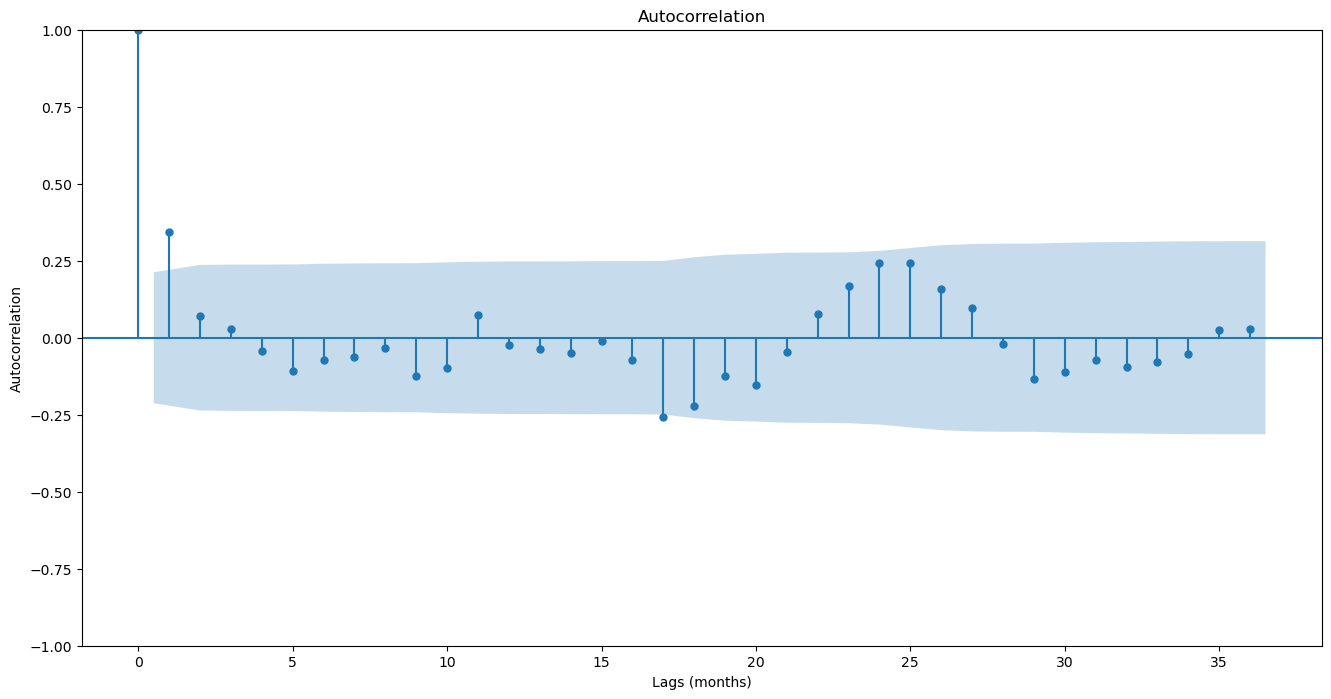

In [196]:
# Autocorrelation (can help us with modelling later)
fig, ax = plt.subplots(figsize=(16,8))
_=plot_acf(data_ds['windspeed'], lags=36, ax=ax) 
_=plt.xlabel('Lags (months)')
_=plt.ylabel('Autocorrelation')

This autocorrelation shows that windspeed feature is related with its past observations.

## Wind Energy Calculation
After having a clear understanding of the data, we can now calculate wind energy generation

In [197]:
# Calculating wind_energy_generation
df['wind_energy_generation'] = df.apply(calculate_wind_electricity, axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 87754 entries, 2014-01-01 00:00:00 to 2024-01-05 09:00:00
Freq: H
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   temp                    87754 non-null  float64
 1   dew                     87754 non-null  float64
 2   humidity                87754 non-null  float64
 3   precip                  87754 non-null  float64
 4   precipprob              87754 non-null  float64
 5   snow                    87754 non-null  float64
 6   snowdepth               87754 non-null  float64
 7   windspeed               87754 non-null  float64
 8   winddir                 87754 non-null  float64
 9   sealevelpressure        87754 non-null  float64
 10  cloudcover              87754 non-null  float64
 11  solarradiation          87754 non-null  float64
 12  uvindex                 87754 non-null  float64
 13  solarenergy             87754 non-null  float64


## Correlation Matrix
We need to shift the wind energy data by 24 hours ahead because we need to predict the wind energy 24 hours in advance.

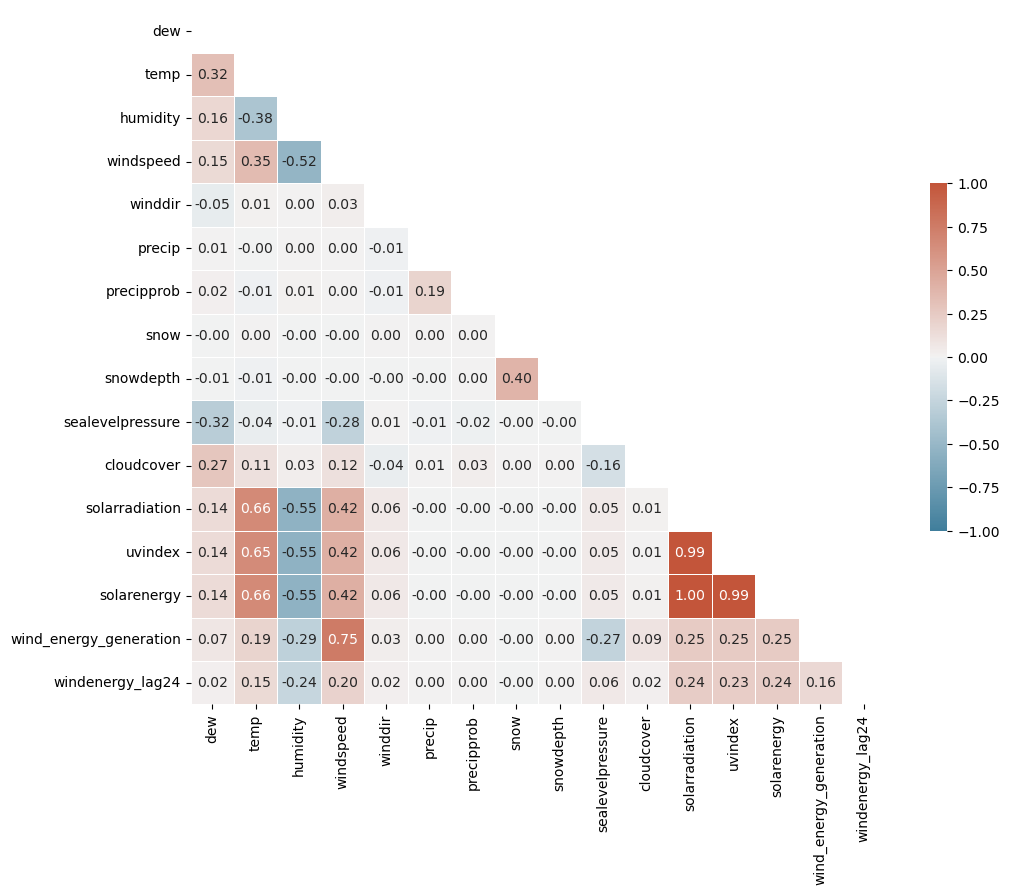

In [198]:
df_copy = df.copy()

# Shift windspeed to 24 hours ahead
df_copy['windenergy_lag24'] = df_copy['wind_energy_generation'].shift(-24)

features = ["dew","temp", "humidity", "windspeed","winddir","precip","precipprob","snow","snowdepth",
            "sealevelpressure","cloudcover","solarradiation","uvindex",
            "solarenergy","wind_energy_generation",'windenergy_lag24']

# Compute the correlation matrix
corr = df_copy[features].diff().corr() 

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, fmt='.2f')
plt.tight_layout()

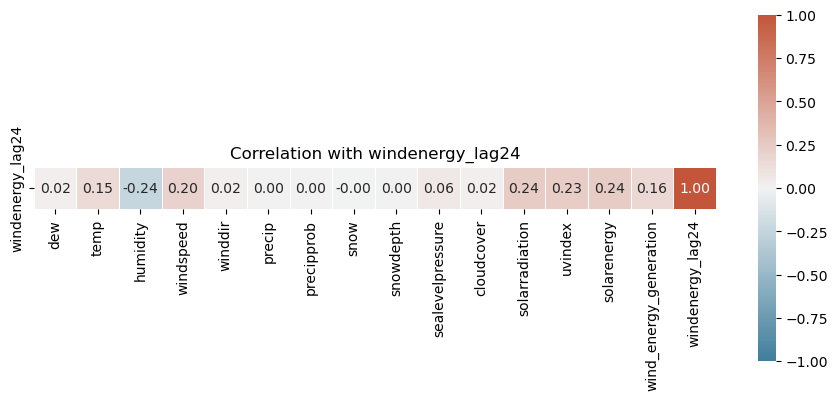

In [199]:
windenergy_lag24_corr = corr.loc[['windenergy_lag24'], :]
# Plotting
plt.figure(figsize=(11, 9))
sns.heatmap(windenergy_lag24_corr, cmap=cmap, vmin=-1, vmax=1, center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, fmt='.2f')
plt.title('Correlation with windenergy_lag24')
plt.show()

In [200]:
# Dropping columns based on the correlation matrix
df = df.drop(columns=["precip","precipprob","snow","snowdepth"])
df

,temp,dew,humidity,windspeed,winddir,sealevelpressure,cloudcover,solarradiation,uvindex,solarenergy,hour,day,month,year,week_of_year,preciptype_rain,"preciptype_rain,snow",preciptype_snow,wind_energy_generation
2014-01-01 00:00:00,5.1,4.000000,92.620000,14.100000,181.000000,1002.500000,6.600000,0.000000,0.0,0.0,0,1,1,2014,1,True,False,False,333.57
2014-01-01 01:00:00,5.9,4.400000,92.420000,17.850000,184.000000,1002.250000,42.050000,0.000000,0.0,0.0,1,1,1,2014,1,False,False,False,676.78
2014-01-01 02:00:00,6.2,4.333333,90.630000,19.666667,188.000000,1002.033333,46.666667,0.000000,0.0,0.0,2,1,1,2014,1,False,False,False,905.16
2014-01-01 03:00:00,6.1,4.300000,90.007500,19.875000,190.000000,1001.750000,42.500000,0.000000,0.0,0.0,3,1,1,2014,1,False,False,False,934.24
2014-01-01 04:00:00,5.7,4.320000,90.278000,19.960000,192.200000,1001.620000,38.300000,0.000000,0.0,0.0,4,1,1,2014,1,False,False,False,946.27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-05 05:00:00,5.2,5.642857,93.120000,18.242857,177.142857,991.800000,96.214286,0.000000,0.0,0.0,5,5,1,2024,1,False,False,False,722.46
2024-01-05 06:00:00,5.2,5.185714,92.705714,20.471429,218.285714,992.000000,97.471429,0.000000,0.0,0.0,6,5,1,2024,1,False,False,False,1020.89
2024-01-05 07:00:00,5.5,4.785714,91.765714,22.485714,249.571429,992.457143,97.971429,0.000000,0.0,0.0,7,5,1,2024,1,False,False,False,1352.87
2024-01-05 08:00:00,5.8,4.514286,91.378571,24.571429,282.714286,993.128571,96.800000,0.000000,0.0,0.0,8,5,1,2024,1,False,False,False,1765.33


In [201]:
train_set = df.loc['2014-01':'2021-12']
validation_set = df.loc['2022-01':'2022-12']
test_set = df.loc['2023-01':]

In [202]:
# Saving data
train_set.to_csv('train_data.csv', index=True)
validation_set.to_csv('validation_data.csv', index=True)
test_set.to_csv('test_data.csv', index=True)